<a href="https://colab.research.google.com/github/AndreisMarco/02456_G128_bird_classification/blob/main/scripts/06_Audio_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [1]:
!pip install datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 1.1 Import libraries

In [2]:
# setting up Drive and path for data loading and saving
import os
from google.colab import drive

# for data processing
import numpy as np
import re
from datasets import Dataset, concatenate_datasets
from transformers import AutoFeatureExtractor

# for model training and evaluation
import torch
from torch import nn
import evaluate
from torch.utils.data import DataLoader
from datetime import datetime

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# enforcing reproducibility - from NLP - lab 2 notebook
import random
import numpy as np

def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

In [5]:
enforce_reproducibility()

## 1.2 Prepare data

In [6]:
# mount Drive and set path
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Deep Learning - DTU 2024/project'
os.chdir(path)

Mounted at /content/drive


In [7]:
# load (one batch of) preprocessed data
# batch_path = 'batch_1'
# dataset = Dataset.load_from_disk(batch_path).remove_columns('__index_level_0__')

In [8]:
# from Marco's code

def sort_numerically(batch_paths):
    '''
    Necessary for standardizing the batches import order
    '''
    def extract_number(batch_dir):
        match = re.search(r'(\d+)', batch_dir)
        return int(match.group(1)) if match else 0
    sorted_paths = sorted(batch_paths, key=extract_number)
    return sorted_paths

def load_and_merge_batches(batch_folder):
    '''
    Loads all .arrow files and merges them in a single dataset
    '''
    print(f"Loading and merging batches from folder: {batch_folder}")
    batch_paths = [f for f in os.listdir(batch_folder) if os.path.isdir(os.path.join(batch_folder, f))]
    batch_paths = sort_numerically(batch_paths)
    datasets_list = []

    for batch_dir in batch_paths:
        batch_path = os.path.join(batch_folder, batch_dir)
        dataset = Dataset.load_from_disk(batch_path)
        datasets_list.append(dataset)

    merged_dataset = concatenate_datasets(datasets_list)
    print(f"Merged {len(datasets_list)} batches into a single dataset.")
    return merged_dataset

In [9]:
dataset = load_and_merge_batches("processed_data")

Loading and merging batches from folder: processed_data
Merged 15 batches into a single dataset.


In [10]:
# inspect structure
dataset = dataset.remove_columns('__index_level_0__')
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 24496
})

In [11]:
dataset[0].keys()

dict_keys(['audio', 'label'])

In [12]:
print(set(dataset['label']))
num_classes = len(set(dataset['label']))
print(f"Number of classes in the dataset: {num_classes}")

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
Number of classes in the dataset: 50


In [13]:
# re-assign classes - takes 3 min
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(dataset["label"])  # Fit on all labels in training set

def remap_labels(batch, label_column='label'):
    batch[label_column] = label_encoder.transform(batch[label_column])
    return batch

dataset = dataset.map(remap_labels, batched=True)
all_classes = np.unique(dataset['label'])
print(f"Renamed classes: {all_classes}")

Map:   0%|          | 0/24496 [00:00<?, ? examples/s]

Renamed classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


### 1.2.1 Feature Extraction

In [14]:
model_dir = 'facebook/wav2vec2-base-960h'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

In [15]:
# extract features - from Marco's code - takes 15 min
# def preprocess_function(example):
#     inputs = feature_extractor(example['audio'], sampling_rate=16000, padding=True)
#     return inputs
# dataset = dataset.map(preprocess_function, remove_columns="audio", batched=True, batch_size=32)
# print("Preprocessed dataset with feature extractor.")

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
all_classes = np.unique(dataset['label'])  # Assuming 'label' is your target column

### 1.2.2 Split Dataset

In [17]:
# split dataset into train, val and test - from Marco's code
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label", seed=42)
print("Split dataset into training and testing.")

Split dataset into training and testing.


### 1.2.3 Compute class weights

In [18]:
class_weights = compute_class_weight('balanced', classes=all_classes, y=dataset['train']['label'])

# Handle missing classes
all_class_weights = {}
for class_id in all_classes:
  if class_id in class_weights:
      all_class_weights[class_id] = class_weights[class_id]
  else:
      all_class_weights[class_id] = 1.0  # or any default weight you prefer
# Convert to Tensor
class_weight_tensor = torch.tensor(list(all_class_weights.values()), dtype=torch.float32).to(device)

In [19]:
all_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [20]:
print(f"Computed class weights: {class_weights}")
print(f"Class weights tensor moved to device: {device}")

Computed class weights: [1.48959459 2.0412963  2.84464516 1.3122619  0.52995192 1.29302053
 1.60919708 2.19363184 0.71461912 0.41130597 2.18277228 0.36289712
 0.62014065 1.33208459 0.65418398 1.32011976 1.02539535 1.3608642
 1.48457912 1.91704348 0.7511414  0.85284333 0.86454902 0.89074747
 1.59753623 1.8144856  0.44313568 2.19363184 0.60152797 1.67015152
 1.26701149 0.41400939 1.76368    1.09955112 1.43155844 1.4177492
 1.79967347 1.74968254 0.85284333 1.55253521 1.38219436 1.71564202
 0.85119691 0.54977556 0.58245707 2.51954286 0.83984762 2.15082927
 3.47181102 0.93613588]
Class weights tensor moved to device: cuda


In [21]:
# from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights and store in a dict
# class_weights = compute_class_weight('balanced', classes=np.unique(dataset['train']['label']), y=dataset['train']['label'])
# class_weights = {class_id: weight for class_id, weight in zip(np.unique(dataset['train']['label']), class_weights)}
# print(f"Computed class weights: {class_weights}")
# # Convert weights to Tensor
# class_weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device)
# print(f"Class weights tensor moved to device: {device}")

### 1.2.4 Dataset to Loader

In [22]:
# from torch.nn.utils.rnn import pad_sequence

MAX_LENGTH = 160000  # Use the longest sequence length in your dataset

def collate_fn(batch):
    inputs = []
    for item in batch:
        input_values = item['audio'].clone().detach()

        # running the line below didn't work properly, I had to manually pad
        # padded_inputs = pad_sequence(inputs, batch_first=True).unsqueeze(1)

        if len(input_values) < MAX_LENGTH: # pad
            padded = torch.cat((input_values, torch.zeros(MAX_LENGTH - len(input_values))))
        else: # truncate
            padded = input_values[:MAX_LENGTH]
        inputs.append(padded)
    labels = torch.tensor([item['label'] for item in batch])
    return torch.stack(inputs).unsqueeze(1), labels

In [23]:
# convert dataset col to tensors
dataset['train'].set_format(type='torch', columns=['audio', 'label'])
dataset['test'].set_format(type='torch', columns=['audio', 'label'])

# 2. Model Training

## 2.1 Initiate CNN

In [24]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(64 * 40000, 256)  # input size should be 160000, which is confirmed wile the model was trained
        self.bn_fc1 = nn.BatchNorm1d(256) # batchnorm didn't really work
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        # debug step:
        # print("Shape after conv1:", x.shape)

        x = self.pool(self.relu(self.conv2(x)))
        # print("Shape after conv2:", x.shape)

        # x = self.pool(self.relu(self.conv3(x)))
        # print("Shape after conv3:", x.shape)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print("Shape after flattening:", x.shape)

        x = self.dropout(self.relu(self.fc1(x)))
        # x = self.dropout(self.relu(self.bn_fc1(self.fc1(x))))
        # print("Shape after fc1:", x.shape)

        x = self.fc2(x)  # Second fully connected layer (output)
        # print("Shape after fc2:", x.shape)
        return x

In [25]:
cnn = AudioCNN(num_classes).to(device)
print(cnn)

AudioCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2560000, out_features=256, bias=True)
  (bn_fc1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (relu): ReLU()
)


## 2.2 Load Loss, Optimizer and Performance Metric

In [26]:
loss_fct = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = torch.optim.Adam(cnn.parameters(), lr=3e-3, weight_decay=1e-3)

In [27]:
# load performace metric: accuracy
accuracy = evaluate.load("accuracy")

## 2.3 Model Training

In [28]:
# directory for model saving
current_time = datetime.now().strftime("%m-%d_%H-%M-%S")
save_dir = f"checkpoints_{current_time}"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
num_epochs = 100
batch_size = 16

# load data
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=batch_size, collate_fn=collate_fn)

# init metric containers
train_iter, train_losses, train_accs = [], [], []
test_iter, test_losses, test_accs = [], [], []

best_val_loss = float('inf')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# train and evaluate
for epoch in range(num_epochs):
  cnn.train()
  step = 0

  if epoch % 5 == 0:
    scheduler.step()

  for inputs, labels in train_loader:
    step += 1

    inputs, labels = inputs.to(device), labels.to(device)
    # print(f"Shape of inputs before passing to model: {inputs.shape}")
    # print(f"Unique values in labels: {torch.unique(labels)}")

    optimizer.zero_grad()
    outputs = cnn(inputs)

    loss = loss_fct(outputs, labels)
    loss.backward()
    optimizer.step()

    if step % 344 == 0:
      train_iter.append(step + epoch*len(train_loader))
      train_losses.append(loss.item())
      train_acc = accuracy.compute(predictions=outputs.argmax(axis=1), references=labels)['accuracy']
      train_accs.append(train_acc)
      print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(train_loader)}], Train loss: {loss.item():.4f}, Train accuracy: {train_acc:.4f}")

      # calculate, append and display evaluation reports
      cnn.eval()
      test_loss, test_acc = 0, 0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = torch.clamp(labels, 0, num_classes - 1).long()
          outputs = cnn(inputs)
          test_loss += loss_fct(outputs, labels).item()
          test_acc += accuracy.compute(predictions=outputs.argmax(axis=1), references=labels)['accuracy']

        # append to reports
        test_iter.append(step + epoch*len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(test_acc / len(test_loader))

        # display reports
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}")

  # At the end of each epoch
  avg_test_loss = test_loss / len(test_loader)
  if avg_test_loss <= best_val_loss:
      best_val_loss = avg_test_loss
      checkpoint_path = os.path.join(save_dir, "best_model.pth")
      torch.save({
          'epoch': epoch + 1,
          'model_state_dict': cnn.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss.item(),
      }, checkpoint_path)
      print(f"New best model saved to {checkpoint_path}")

print('')
print(f'Final training loss: {str(train_losses[-1])} accuracy: {str(train_accs[-1])}')
print(f'Final validation loss: {str(test_losses[-1])} accuracy: {str(test_accs[-1])}')


# Save the final model - with datetime_id

final_model_path =  os.path.join(save_dir, f"/final_model.pth")
torch.save(cnn.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")

Epoch [1/100], Step [344/1378], Train loss: 3.6036, Train accuracy: 0.1250
Test Loss: 3.7445, Test Accuracy: 0.0625
Epoch [1/100], Step [688/1378], Train loss: 3.7669, Train accuracy: 0.0625
Test Loss: 3.8164, Test Accuracy: 0.0617
Epoch [1/100], Step [1032/1378], Train loss: 3.7901, Train accuracy: 0.0000
Test Loss: 3.7561, Test Accuracy: 0.0491
Epoch [1/100], Step [1376/1378], Train loss: 3.8324, Train accuracy: 0.0625
Test Loss: 3.7068, Test Accuracy: 0.0698
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [2/100], Step [344/1378], Train loss: 3.6131, Train accuracy: 0.1250
Test Loss: 3.7128, Test Accuracy: 0.0698
Epoch [2/100], Step [688/1378], Train loss: 3.7222, Train accuracy: 0.0000
Test Loss: 3.7533, Test Accuracy: 0.0617
Epoch [2/100], Step [1032/1378], Train loss: 3.5447, Train accuracy: 0.1250
Test Loss: 3.6504, Test Accuracy: 0.0889
Epoch [2/100], Step [1376/1378], Train loss: 3.5795, Train accuracy: 0.0625
Test Loss: 3.5910, Test Accuracy: 0.1027
Ne

In [ ]:
# code for resuming
# checkpoint = torch.load("checkpoints/model_epoch_X.pth")  # Replace X with the desired epoch
# cnn.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# loss = checkpoint['loss']

## 2.4 Plot Performance

In [ ]:
train_iter

In [16]:
# Initialize lists
train_iter, train_losses, train_accs = [], [], []
test_iter, test_losses, test_accs = [], [], []

# Parse the log data
log_data = """
Epoch [1/100], Step [1032/1378], Train loss: 3.7901, Train accuracy: 0.0000
Test Loss: 3.7561, Test Accuracy: 0.0491
Epoch [1/100], Step [1376/1378], Train loss: 3.8324, Train accuracy: 0.0625
Test Loss: 3.7068, Test Accuracy: 0.0698
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [2/100], Step [344/1378], Train loss: 3.6131, Train accuracy: 0.1250
Test Loss: 3.7128, Test Accuracy: 0.0698
Epoch [2/100], Step [688/1378], Train loss: 3.7222, Train accuracy: 0.0000
Test Loss: 3.7533, Test Accuracy: 0.0617
Epoch [2/100], Step [1032/1378], Train loss: 3.5447, Train accuracy: 0.1250
Test Loss: 3.6504, Test Accuracy: 0.0889
Epoch [2/100], Step [1376/1378], Train loss: 3.5795, Train accuracy: 0.0625
Test Loss: 3.5910, Test Accuracy: 0.1027
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [3/100], Step [344/1378], Train loss: 3.4251, Train accuracy: 0.0625
Test Loss: 3.5631, Test Accuracy: 0.0966
Epoch [3/100], Step [688/1378], Train loss: 3.7744, Train accuracy: 0.1250
Test Loss: 3.4964, Test Accuracy: 0.1120
Epoch [3/100], Step [1032/1378], Train loss: 3.1843, Train accuracy: 0.1875
Test Loss: 3.4181, Test Accuracy: 0.1449
Epoch [3/100], Step [1376/1378], Train loss: 3.4223, Train accuracy: 0.1250
Test Loss: 3.2683, Test Accuracy: 0.1571
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [4/100], Step [344/1378], Train loss: 3.2033, Train accuracy: 0.1875
Test Loss: 3.3602, Test Accuracy: 0.1477
Epoch [4/100], Step [688/1378], Train loss: 3.6188, Train accuracy: 0.1250
Test Loss: 3.2131, Test Accuracy: 0.1721
Epoch [4/100], Step [1032/1378], Train loss: 3.3128, Train accuracy: 0.1875
Test Loss: 3.1034, Test Accuracy: 0.2074
Epoch [4/100], Step [1376/1378], Train loss: 3.3543, Train accuracy: 0.1875
Test Loss: 3.0403, Test Accuracy: 0.2240
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [5/100], Step [344/1378], Train loss: 3.1288, Train accuracy: 0.2500
Test Loss: 3.2376, Test Accuracy: 0.1761
Epoch [5/100], Step [688/1378], Train loss: 3.4661, Train accuracy: 0.1250
Test Loss: 3.0555, Test Accuracy: 0.2041
Epoch [5/100], Step [1032/1378], Train loss: 2.7904, Train accuracy: 0.1875
Test Loss: 3.3812, Test Accuracy: 0.2342
Epoch [5/100], Step [1376/1378], Train loss: 2.9936, Train accuracy: 0.2500
Test Loss: 2.8265, Test Accuracy: 0.2845
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [6/100], Step [344/1378], Train loss: 3.1345, Train accuracy: 0.0625
Test Loss: 3.0914, Test Accuracy: 0.2200
Epoch [6/100], Step [688/1378], Train loss: 3.6664, Train accuracy: 0.1875
Test Loss: 2.9457, Test Accuracy: 0.2411
Epoch [6/100], Step [1032/1378], Train loss: 2.9711, Train accuracy: 0.2500
Test Loss: 2.7617, Test Accuracy: 0.3137
Epoch [6/100], Step [1376/1378], Train loss: 2.7794, Train accuracy: 0.2500
Test Loss: 2.7304, Test Accuracy: 0.3340
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [7/100], Step [344/1378], Train loss: 3.1638, Train accuracy: 0.1250
Test Loss: 2.9546, Test Accuracy: 0.2447
Epoch [7/100], Step [688/1378], Train loss: 2.7254, Train accuracy: 0.3750
Test Loss: 2.7476, Test Accuracy: 0.3364
Epoch [7/100], Step [1032/1378], Train loss: 2.5637, Train accuracy: 0.3125
Test Loss: 2.6777, Test Accuracy: 0.3421
Epoch [7/100], Step [1376/1378], Train loss: 2.9065, Train accuracy: 0.3125
Test Loss: 2.6218, Test Accuracy: 0.3811
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [8/100], Step [344/1378], Train loss: 2.9469, Train accuracy: 0.2500
Test Loss: 2.8309, Test Accuracy: 0.3174
Epoch [8/100], Step [688/1378], Train loss: 2.7946, Train accuracy: 0.4375
Test Loss: 2.7088, Test Accuracy: 0.3429
Epoch [8/100], Step [1032/1378], Train loss: 2.5709, Train accuracy: 0.4375
Test Loss: 2.6463, Test Accuracy: 0.3612
Epoch [8/100], Step [1376/1378], Train loss: 2.8229, Train accuracy: 0.2500
Test Loss: 2.7942, Test Accuracy: 0.3040
Epoch [9/100], Step [344/1378], Train loss: 2.9315, Train accuracy: 0.3125
Test Loss: 2.8462, Test Accuracy: 0.3125
Epoch [9/100], Step [688/1378], Train loss: 2.3827, Train accuracy: 0.3750
Test Loss: 2.6945, Test Accuracy: 0.3515
Epoch [9/100], Step [1032/1378], Train loss: 2.3622, Train accuracy: 0.3125
Test Loss: 2.6502, Test Accuracy: 0.3778
Epoch [9/100], Step [1376/1378], Train loss: 2.4986, Train accuracy: 0.3750
Test Loss: 2.4943, Test Accuracy: 0.3994
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [10/100], Step [344/1378], Train loss: 2.4599, Train accuracy: 0.3750
Test Loss: 2.7976, Test Accuracy: 0.3377
Epoch [10/100], Step [688/1378], Train loss: 2.3488, Train accuracy: 0.3750
Test Loss: 2.6101, Test Accuracy: 0.3815
Epoch [10/100], Step [1032/1378], Train loss: 1.7705, Train accuracy: 0.6250
Test Loss: 2.5070, Test Accuracy: 0.4014
Epoch [10/100], Step [1376/1378], Train loss: 2.6968, Train accuracy: 0.2500
Test Loss: 2.4932, Test Accuracy: 0.4217
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [11/100], Step [344/1378], Train loss: 3.1095, Train accuracy: 0.2500
Test Loss: 2.7332, Test Accuracy: 0.3474
Epoch [11/100], Step [688/1378], Train loss: 1.9119, Train accuracy: 0.5000
Test Loss: 2.5641, Test Accuracy: 0.4042
Epoch [11/100], Step [1032/1378], Train loss: 1.7170, Train accuracy: 0.5625
Test Loss: 2.4728, Test Accuracy: 0.4407
Epoch [11/100], Step [1376/1378], Train loss: 2.2524, Train accuracy: 0.3750
Test Loss: 2.5020, Test Accuracy: 0.4395
Epoch [12/100], Step [344/1378], Train loss: 2.9214, Train accuracy: 0.3125
Test Loss: 2.7049, Test Accuracy: 0.3661
Epoch [12/100], Step [688/1378], Train loss: 2.0544, Train accuracy: 0.4375
Test Loss: 2.6630, Test Accuracy: 0.3937
Epoch [12/100], Step [1032/1378], Train loss: 1.4881, Train accuracy: 0.6250
Test Loss: 2.5917, Test Accuracy: 0.4213
Epoch [12/100], Step [1376/1378], Train loss: 2.2466, Train accuracy: 0.4375
Test Loss: 2.4655, Test Accuracy: 0.4245
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [13/100], Step [344/1378], Train loss: 2.6634, Train accuracy: 0.3750
Test Loss: 2.5758, Test Accuracy: 0.3803
Epoch [13/100], Step [688/1378], Train loss: 2.2161, Train accuracy: 0.3750
Test Loss: 2.5366, Test Accuracy: 0.4221
Epoch [13/100], Step [1032/1378], Train loss: 1.9505, Train accuracy: 0.5625
Test Loss: 2.5447, Test Accuracy: 0.4326
Epoch [13/100], Step [1376/1378], Train loss: 2.3021, Train accuracy: 0.3750
Test Loss: 2.4419, Test Accuracy: 0.4679
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [14/100], Step [344/1378], Train loss: 2.5546, Train accuracy: 0.3125
Test Loss: 2.5689, Test Accuracy: 0.4026
Epoch [14/100], Step [688/1378], Train loss: 1.5635, Train accuracy: 0.5000
Test Loss: 2.4838, Test Accuracy: 0.4403
Epoch [14/100], Step [1032/1378], Train loss: 1.6454, Train accuracy: 0.5000
Test Loss: 2.5579, Test Accuracy: 0.4407
Epoch [14/100], Step [1376/1378], Train loss: 2.0472, Train accuracy: 0.4375
Test Loss: 2.3798, Test Accuracy: 0.4789
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [15/100], Step [344/1378], Train loss: 2.8995, Train accuracy: 0.3125
Test Loss: 2.8691, Test Accuracy: 0.3024
Epoch [15/100], Step [688/1378], Train loss: 1.8071, Train accuracy: 0.5000
Test Loss: 2.5999, Test Accuracy: 0.4253
Epoch [15/100], Step [1032/1378], Train loss: 1.6429, Train accuracy: 0.5000
Test Loss: 2.5257, Test Accuracy: 0.4716
Epoch [15/100], Step [1376/1378], Train loss: 1.6961, Train accuracy: 0.5000
Test Loss: 2.3837, Test Accuracy: 0.4744
Epoch [16/100], Step [344/1378], Train loss: 2.4556, Train accuracy: 0.3750
Test Loss: 2.6364, Test Accuracy: 0.3649
Epoch [16/100], Step [688/1378], Train loss: 2.1359, Train accuracy: 0.4375
Test Loss: 2.7607, Test Accuracy: 0.4229
Epoch [16/100], Step [1032/1378], Train loss: 1.3561, Train accuracy: 0.6250
Test Loss: 2.6858, Test Accuracy: 0.4627
Epoch [16/100], Step [1376/1378], Train loss: 1.9491, Train accuracy: 0.2500
Test Loss: 2.3144, Test Accuracy: 0.4935
New best model saved to checkpoints_11-28_13-26-29/best_model.pth
Epoch [17/100], Step [344/1378], Train loss: 2.6508, Train accuracy: 0.3750
Test Loss: 2.5126, Test Accuracy: 0.4217
Epoch [17/100], Step [688/1378], Train loss: 1.5258, Train accuracy: 0.5625
Test Loss: 2.7181, Test Accuracy: 0.4310
Epoch [17/100], Step [1032/1378], Train loss: 1.7199, Train accuracy: 0.6875
Test Loss: 2.5656, Test Accuracy: 0.4696
Epoch [17/100], Step [1376/1378], Train loss: 1.4561, Train accuracy: 0.5000
Test Loss: 2.4169, Test Accuracy: 0.4838
Epoch [18/100], Step [344/1378], Train loss: 2.7861, Train accuracy: 0.3125
Test Loss: 2.5509, Test Accuracy: 0.4038
Epoch [18/100], Step [688/1378], Train loss: 1.5686, Train accuracy: 0.5000
Test Loss: 2.5528, Test Accuracy: 0.4371
Epoch [18/100], Step [1032/1378], Train loss: 1.3963, Train accuracy: 0.6875
Test Loss: 2.7530, Test Accuracy: 0.4566
Epoch [18/100], Step [1376/1378], Train loss: 1.8796, Train accuracy: 0.3750
Test Loss: 2.6232, Test Accuracy: 0.4797
Epoch [19/100], Step [344/1378], Train loss: 2.9727, Train accuracy: 0.2500
Test Loss: 2.6178, Test Accuracy: 0.3868
Epoch [19/100], Step [688/1378], Train loss: 1.3719, Train accuracy: 0.7500
Test Loss: 2.6299, Test Accuracy: 0.4700
Epoch [19/100], Step [1032/1378], Train loss: 1.1463, Train accuracy: 0.6250
Test Loss: 2.6307, Test Accuracy: 0.4704
Epoch [19/100], Step [1376/1378], Train loss: 1.7520, Train accuracy: 0.4375
Test Loss: 2.4484, Test Accuracy: 0.5020
Epoch [20/100], Step [344/1378], Train loss: 2.9013, Train accuracy: 0.3750
Test Loss: 2.5434, Test Accuracy: 0.3843
Epoch [20/100], Step [688/1378], Train loss: 1.7016, Train accuracy: 0.5000
Test Loss: 2.7306, Test Accuracy: 0.4481
Epoch [20/100], Step [1032/1378], Train loss: 2.3137, Train accuracy: 0.5625
Test Loss: 2.5381, Test Accuracy: 0.4578
Epoch [20/100], Step [1376/1378], Train loss: 1.6372, Train accuracy: 0.5000
Test Loss: 2.5051, Test Accuracy: 0.4809
Epoch [21/100], Step [344/1378], Train loss: 2.4843, Train accuracy: 0.5000
Test Loss: 2.3519, Test Accuracy: 0.4651
Epoch [21/100], Step [688/1378], Train loss: 1.1689, Train accuracy: 0.6250
Test Loss: 2.4559, Test Accuracy: 0.5158
Epoch [21/100], Step [1032/1378], Train loss: 1.2383, Train accuracy: 0.6875
Test Loss: 2.3363, Test Accuracy: 0.5446
Epoch [21/100], Step [1376/1378], Train loss: 1.2590, Train accuracy: 0.6250
Test Loss: 2.4830, Test Accuracy: 0.5377
Epoch [22/100], Step [344/1378], Train loss: 2.2477, Train accuracy: 0.4375
Test Loss: 2.2532, Test Accuracy: 0.4915
Epoch [22/100], Step [688/1378], Train loss: 0.5561, Train accuracy: 0.8750
Test Loss: 2.4290, Test Accuracy: 0.5300
Epoch [22/100], Step [1032/1378], Train loss: 1.5572, Train accuracy: 0.5625
Test Loss: 2.3227, Test Accuracy: 0.5609
Epoch [22/100], Step [1376/1378], Train loss: 1.2849, Train accuracy: 0.6250
Test Loss: 2.6550, Test Accuracy: 0.5276
Epoch [23/100], Step [344/1378], Train loss: 2.0566, Train accuracy: 0.5000
Test Loss: 2.2188, Test Accuracy: 0.4992
Epoch [23/100], Step [688/1378], Train loss: 0.8884, Train accuracy: 0.7500
Test Loss: 2.7889, Test Accuracy: 0.5154
Epoch [23/100], Step [1032/1378], Train loss: 1.0429, Train accuracy: 0.8750
Test Loss: 2.6314, Test Accuracy: 0.5475
Epoch [23/100], Step [1376/1378], Train loss: 0.9568, Train accuracy: 0.6875
Test Loss: 2.7758, Test Accuracy: 0.5361
Epoch [24/100], Step [344/1378], Train loss: 2.4785, Train accuracy: 0.3750
Test Loss: 2.1903, Test Accuracy: 0.5028
Epoch [24/100], Step [688/1378], Train loss: 0.8413, Train accuracy: 0.8125
Test Loss: 2.4665, Test Accuracy: 0.5536
Epoch [24/100], Step [1032/1378], Train loss: 0.7591, Train accuracy: 0.8125
Test Loss: 2.7993, Test Accuracy: 0.5515
Epoch [24/100], Step [1376/1378], Train loss: 0.9268, Train accuracy: 0.6875
Test Loss: 2.7229, Test Accuracy: 0.5580
Epoch [25/100], Step [344/1378], Train loss: 2.3699, Train accuracy: 0.3750
Test Loss: 2.1971, Test Accuracy: 0.5077
Epoch [25/100], Step [688/1378], Train loss: 0.4993, Train accuracy: 0.8750
Test Loss: 2.5684, Test Accuracy: 0.5556
Epoch [25/100], Step [1032/1378], Train loss: 0.8203, Train accuracy: 0.7500
Test Loss: 2.6777, Test Accuracy: 0.5532
Epoch [25/100], Step [1376/1378], Train loss: 0.7396, Train accuracy: 0.8125
Test Loss: 2.8799, Test Accuracy: 0.5605
Epoch [26/100], Step [344/1378], Train loss: 1.5277, Train accuracy: 0.5625
Test Loss: 2.1535, Test Accuracy: 0.5065
Epoch [26/100], Step [688/1378], Train loss: 0.9882, Train accuracy: 0.8125
Test Loss: 2.6485, Test Accuracy: 0.5463
Epoch [26/100], Step [1032/1378], Train loss: 1.4019, Train accuracy: 0.8750
Test Loss: 2.6900, Test Accuracy: 0.5593
Epoch [26/100], Step [1376/1378], Train loss: 0.6074, Train accuracy: 0.9375
Test Loss: 2.7241, Test Accuracy: 0.5544
Epoch [27/100], Step [344/1378], Train loss: 1.8016, Train accuracy: 0.5000
Test Loss: 2.1487, Test Accuracy: 0.5175
Epoch [27/100], Step [688/1378], Train loss: 0.5026, Train accuracy: 0.8750
Test Loss: 2.7135, Test Accuracy: 0.5662
Epoch [27/100], Step [1032/1378], Train loss: 1.0809, Train accuracy: 0.8750
Test Loss: 2.5958, Test Accuracy: 0.5666
Epoch [27/100], Step [1376/1378], Train loss: 0.8160, Train accuracy: 0.6875
Test Loss: 2.7614, Test Accuracy: 0.5633
Epoch [28/100], Step [344/1378], Train loss: 2.1627, Train accuracy: 0.4375
Test Loss: 2.0894, Test Accuracy: 0.5373
Epoch [28/100], Step [688/1378], Train loss: 0.1792, Train accuracy: 1.0000
Test Loss: 2.7733, Test Accuracy: 0.5844
Epoch [28/100], Step [1032/1378], Train loss: 0.6407, Train accuracy: 0.9375
Test Loss: 2.5225, Test Accuracy: 0.5726
Epoch [28/100], Step [1376/1378], Train loss: 0.4722, Train accuracy: 0.9375
Test Loss: 2.6968, Test Accuracy: 0.5739
Epoch [29/100], Step [344/1378], Train loss: 2.2753, Train accuracy: 0.5000
Test Loss: 2.0387, Test Accuracy: 0.5519
Epoch [29/100], Step [688/1378], Train loss: 1.1226, Train accuracy: 0.7500
Test Loss: 2.9756, Test Accuracy: 0.5548
Epoch [29/100], Step [1032/1378], Train loss: 0.7561, Train accuracy: 0.8125
Test Loss: 2.8239, Test Accuracy: 0.5617
Epoch [29/100], Step [1376/1378], Train loss: 0.8733, Train accuracy: 0.8125
Test Loss: 2.7662, Test Accuracy: 0.5714
Epoch [30/100], Step [344/1378], Train loss: 2.5994, Train accuracy: 0.2500
Test Loss: 2.1280, Test Accuracy: 0.5085
Epoch [30/100], Step [688/1378], Train loss: 0.2231, Train accuracy: 0.9375
Test Loss: 2.9593, Test Accuracy: 0.5584
Epoch [30/100], Step [1032/1378], Train loss: 1.1433, Train accuracy: 0.8750
Test Loss: 2.8558, Test Accuracy: 0.5645
Epoch [30/100], Step [1376/1378], Train loss: 0.8758, Train accuracy: 0.8125
Test Loss: 2.8692, Test Accuracy: 0.5511
Epoch [31/100], Step [344/1378], Train loss: 1.4492, Train accuracy: 0.5625
Test Loss: 2.0853, Test Accuracy: 0.5357
Epoch [31/100], Step [688/1378], Train loss: 0.2678, Train accuracy: 0.9375
Test Loss: 2.6765, Test Accuracy: 0.5751
Epoch [31/100], Step [1032/1378], Train loss: 0.6359, Train accuracy: 0.8125
Test Loss: 2.8499, Test Accuracy: 0.5702
Epoch [31/100], Step [1376/1378], Train loss: 0.6575, Train accuracy: 0.8750
Test Loss: 2.7960, Test Accuracy: 0.5649
Epoch [32/100], Step [344/1378], Train loss: 2.0886, Train accuracy: 0.3750
Test Loss: 2.1046, Test Accuracy: 0.5231
Epoch [32/100], Step [688/1378], Train loss: 1.5911, Train accuracy: 0.6875
Test Loss: 2.8167, Test Accuracy: 0.5597
Epoch [32/100], Step [1032/1378], Train loss: 1.1839, Train accuracy: 0.7500
Test Loss: 2.7293, Test Accuracy: 0.5804
Epoch [32/100], Step [1376/1378], Train loss: 0.3460, Train accuracy: 1.0000
Test Loss: 2.7645, Test Accuracy: 0.5763
Epoch [33/100], Step [344/1378], Train loss: 2.5933, Train accuracy: 0.1875
Test Loss: 2.1093, Test Accuracy: 0.5223
Epoch [33/100], Step [688/1378], Train loss: 0.2649, Train accuracy: 1.0000
Test Loss: 2.8828, Test Accuracy: 0.5710
Epoch [33/100], Step [1032/1378], Train loss: 0.4462, Train accuracy: 0.9375
Test Loss: 2.8164, Test Accuracy: 0.5580
Epoch [33/100], Step [1376/1378], Train loss: 0.4117, Train accuracy: 1.0000
Test Loss: 2.7447, Test Accuracy: 0.5718
Epoch [34/100], Step [344/1378], Train loss: 2.7141, Train accuracy: 0.2500
Test Loss: 2.0977, Test Accuracy: 0.5288
Epoch [34/100], Step [688/1378], Train loss: 0.2066, Train accuracy: 0.9375
Test Loss: 2.6323, Test Accuracy: 0.5824
Epoch [34/100], Step [1032/1378], Train loss: 0.5376, Train accuracy: 0.8750
Test Loss: 2.8353, Test Accuracy: 0.5791
Epoch [34/100], Step [1376/1378], Train loss: 0.9560, Train accuracy: 0.6250
Test Loss: 2.8265, Test Accuracy: 0.5580
Epoch [35/100], Step [344/1378], Train loss: 1.7808, Train accuracy: 0.5000
Test Loss: 2.1247, Test Accuracy: 0.5300
Epoch [35/100], Step [688/1378], Train loss: 0.4733, Train accuracy: 0.8750
Test Loss: 2.9258, Test Accuracy: 0.5751
Epoch [35/100], Step [1032/1378], Train loss: 0.4296, Train accuracy: 0.9375
Test Loss: 2.8195, Test Accuracy: 0.5722
Epoch [35/100], Step [1376/1378], Train loss: 0.8112, Train accuracy: 0.8125
Test Loss: 2.9132, Test Accuracy: 0.5800
Epoch [36/100], Step [344/1378], Train loss: 2.2005, Train accuracy: 0.4375
Test Loss: 2.2201, Test Accuracy: 0.4943
Epoch [36/100], Step [688/1378], Train loss: 0.5001, Train accuracy: 0.8125
Test Loss: 2.9538, Test Accuracy: 0.5682
Epoch [36/100], Step [1032/1378], Train loss: 0.8553, Train accuracy: 0.8125
Test Loss: 2.7975, Test Accuracy: 0.5925
Epoch [36/100], Step [1376/1378], Train loss: 0.3833, Train accuracy: 0.9375
Test Loss: 2.7940, Test Accuracy: 0.5864
Epoch [37/100], Step [344/1378], Train loss: 2.0209, Train accuracy: 0.4375
Test Loss: 2.1256, Test Accuracy: 0.5166
Epoch [37/100], Step [688/1378], Train loss: 0.2521, Train accuracy: 1.0000
Test Loss: 2.6781, Test Accuracy: 0.5921
Epoch [37/100], Step [1032/1378], Train loss: 0.4638, Train accuracy: 0.8125
Test Loss: 2.7829, Test Accuracy: 0.5820
Epoch [37/100], Step [1376/1378], Train loss: 0.7589, Train accuracy: 0.7500
Test Loss: 2.7420, Test Accuracy: 0.5885
Epoch [38/100], Step [344/1378], Train loss: 2.0109, Train accuracy: 0.5000
Test Loss: 2.0790, Test Accuracy: 0.5268
Epoch [38/100], Step [688/1378], Train loss: 0.4378, Train accuracy: 0.8750
Test Loss: 2.8017, Test Accuracy: 0.5795
Epoch [38/100], Step [1032/1378], Train loss: 0.2737, Train accuracy: 0.9375
Test Loss: 2.8033, Test Accuracy: 0.5791
Epoch [38/100], Step [1376/1378], Train loss: 0.4309, Train accuracy: 0.8125
Test Loss: 2.7856, Test Accuracy: 0.5893
Epoch [39/100], Step [344/1378], Train loss: 2.2432, Train accuracy: 0.4375
Test Loss: 2.1119, Test Accuracy: 0.5333
Epoch [39/100], Step [688/1378], Train loss: 0.9610, Train accuracy: 0.7500
Test Loss: 3.1558, Test Accuracy: 0.5564
Epoch [39/100], Step [1032/1378], Train loss: 0.2150, Train accuracy: 0.9375
Test Loss: 2.9278, Test Accuracy: 0.5751
Epoch [39/100], Step [1376/1378], Train loss: 0.5597, Train accuracy: 0.7500
Test Loss: 2.9850, Test Accuracy: 0.5645
Epoch [40/100], Step [344/1378], Train loss: 1.8561, Train accuracy: 0.5000
Test Loss: 2.0271, Test Accuracy: 0.5576
Epoch [40/100], Step [688/1378], Train loss: 0.2625, Train accuracy: 0.9375
Test Loss: 2.8748, Test Accuracy: 0.5925
Epoch [40/100], Step [1032/1378], Train loss: 0.6774, Train accuracy: 0.6250
Test Loss: 2.6540, Test Accuracy: 0.5893
Epoch [40/100], Step [1376/1378], Train loss: 0.6428, Train accuracy: 0.8125
Test Loss: 2.9605, Test Accuracy: 0.5889
Epoch [41/100], Step [344/1378], Train loss: 2.0379, Train accuracy: 0.4375
Test Loss: 2.0577, Test Accuracy: 0.5446
Epoch [41/100], Step [688/1378], Train loss: 0.7370, Train accuracy: 0.6250
Test Loss: 2.8379, Test Accuracy: 0.5820
Epoch [41/100], Step [1032/1378], Train loss: 1.2946, Train accuracy: 0.8750
Test Loss: 2.9198, Test Accuracy: 0.5881
Epoch [41/100], Step [1376/1378], Train loss: 0.3005, Train accuracy: 0.9375
Test Loss: 3.4437, Test Accuracy: 0.5536
Epoch [42/100], Step [344/1378], Train loss: 2.0430, Train accuracy: 0.4375
Test Loss: 2.0843, Test Accuracy: 0.5483
Epoch [42/100], Step [688/1378], Train loss: 0.3074, Train accuracy: 0.8750
Test Loss: 2.6561, Test Accuracy: 0.5860
Epoch [42/100], Step [1032/1378], Train loss: 0.5472, Train accuracy: 0.9375
Test Loss: 2.7772, Test Accuracy: 0.5856
Epoch [42/100], Step [1376/1378], Train loss: 0.4950, Train accuracy: 0.8125
Test Loss: 2.9640, Test Accuracy: 0.5783
Epoch [43/100], Step [344/1378], Train loss: 2.0836, Train accuracy: 0.5000
Test Loss: 2.0745, Test Accuracy: 0.5353
Epoch [43/100], Step [688/1378], Train loss: 0.8656, Train accuracy: 0.7500
Test Loss: 2.8246, Test Accuracy: 0.5731
Epoch [43/100], Step [1032/1378], Train loss: 0.6488, Train accuracy: 0.8750
Test Loss: 2.6907, Test Accuracy: 0.5824
Epoch [43/100], Step [1376/1378], Train loss: 0.2831, Train accuracy: 0.9375
Test Loss: 2.9499, Test Accuracy: 0.5938
Epoch [44/100], Step [344/1378], Train loss: 1.7070, Train accuracy: 0.5625
Test Loss: 2.0124, Test Accuracy: 0.5524
Epoch [44/100], Step [688/1378], Train loss: 0.3371, Train accuracy: 0.9375
Test Loss: 2.6836, Test Accuracy: 0.5791
Epoch [44/100], Step [1032/1378], Train loss: 0.7139, Train accuracy: 0.9375
Test Loss: 3.1510, Test Accuracy: 0.5804
Epoch [44/100], Step [1376/1378], Train loss: 0.4060, Train accuracy: 0.9375
Test Loss: 3.2256, Test Accuracy: 0.5710
Epoch [45/100], Step [344/1378], Train loss: 1.9974, Train accuracy: 0.5000
Test Loss: 2.0516, Test Accuracy: 0.5394
Epoch [45/100], Step [688/1378], Train loss: 0.5689, Train accuracy: 0.7500
Test Loss: 2.8884, Test Accuracy: 0.5869
Epoch [45/100], Step [1032/1378], Train loss: 0.5602, Train accuracy: 0.9375
Test Loss: 2.5645, Test Accuracy: 0.5877
Epoch [45/100], Step [1376/1378], Train loss: 0.4728, Train accuracy: 0.7500
Test Loss: 3.0747, Test Accuracy: 0.5706
Epoch [46/100], Step [344/1378], Train loss: 1.7795, Train accuracy: 0.4375
Test Loss: 1.9517, Test Accuracy: 0.5670
Epoch [46/100], Step [688/1378], Train loss: 0.2449, Train accuracy: 0.9375
Test Loss: 2.7919, Test Accuracy: 0.6063
Epoch [46/100], Step [1032/1378], Train loss: 0.3158, Train accuracy: 0.8750
Test Loss: 2.7945, Test Accuracy: 0.6149
Epoch [46/100], Step [1376/1378], Train loss: 0.1968, Train accuracy: 1.0000
Test Loss: 2.8332, Test Accuracy: 0.6023
Epoch [47/100], Step [344/1378], Train loss: 1.7359, Train accuracy: 0.5625
Test Loss: 1.9249, Test Accuracy: 0.5808
Epoch [47/100], Step [688/1378], Train loss: 0.1480, Train accuracy: 0.9375
Test Loss: 2.8302, Test Accuracy: 0.6104
Epoch [47/100], Step [1032/1378], Train loss: 0.6321, Train accuracy: 0.8750
Test Loss: 2.6018, Test Accuracy: 0.6120
Epoch [47/100], Step [1376/1378], Train loss: 0.3471, Train accuracy: 0.8750
Test Loss: 2.9402, Test Accuracy: 0.6063
Epoch [48/100], Step [344/1378], Train loss: 2.2592, Train accuracy: 0.4375
Test Loss: 1.8821, Test Accuracy: 0.5873
Epoch [48/100], Step [688/1378], Train loss: 0.1240, Train accuracy: 1.0000
Test Loss: 2.7504, Test Accuracy: 0.6092
Epoch [48/100], Step [1032/1378], Train loss: 0.2194, Train accuracy: 0.8750
Test Loss: 2.6956, Test Accuracy: 0.6108
Epoch [48/100], Step [1376/1378], Train loss: 0.2212, Train accuracy: 1.0000
Test Loss: 2.8836, Test Accuracy: 0.6071
Epoch [49/100], Step [344/1378], Train loss: 1.2984, Train accuracy: 0.6250
Test Loss: 1.9147, Test Accuracy: 0.5852
Epoch [49/100], Step [688/1378], Train loss: 0.1807, Train accuracy: 0.9375
Test Loss: 2.6487, Test Accuracy: 0.6075
Epoch [49/100], Step [1032/1378], Train loss: 0.4713, Train accuracy: 0.9375
Test Loss: 2.7458, Test Accuracy: 0.6120
Epoch [49/100], Step [1376/1378], Train loss: 0.1961, Train accuracy: 1.0000
Test Loss: 2.8532, Test Accuracy: 0.6023
Epoch [50/100], Step [344/1378], Train loss: 1.7278, Train accuracy: 0.5625
Test Loss: 1.9331, Test Accuracy: 0.5812
Epoch [50/100], Step [688/1378], Train loss: 0.1036, Train accuracy: 1.0000
Test Loss: 2.6333, Test Accuracy: 0.6128
Epoch [50/100], Step [1032/1378], Train loss: 0.2901, Train accuracy: 0.8750
Test Loss: 2.6438, Test Accuracy: 0.6173
Epoch [50/100], Step [1376/1378], Train loss: 0.4470, Train accuracy: 0.8125
Test Loss: 3.0569, Test Accuracy: 0.6116
Epoch [51/100], Step [344/1378], Train loss: 1.6481, Train accuracy: 0.5000
Test Loss: 1.9141, Test Accuracy: 0.5860
Epoch [51/100], Step [688/1378], Train loss: 0.1713, Train accuracy: 0.9375
Test Loss: 2.8986, Test Accuracy: 0.6092
Epoch [51/100], Step [1032/1378], Train loss: 0.4969, Train accuracy: 0.8125
Test Loss: 2.9420, Test Accuracy: 0.6132
Epoch [51/100], Step [1376/1378], Train loss: 0.2704, Train accuracy: 0.9375
Test Loss: 3.0085, Test Accuracy: 0.6047
Epoch [52/100], Step [344/1378], Train loss: 1.8277, Train accuracy: 0.5000
Test Loss: 1.9140, Test Accuracy: 0.5844
Epoch [52/100], Step [688/1378], Train loss: 0.0963, Train accuracy: 1.0000
Test Loss: 2.7635, Test Accuracy: 0.6055
Epoch [52/100], Step [1032/1378], Train loss: 0.1487, Train accuracy: 0.9375
Test Loss: 2.6845, Test Accuracy: 0.6161
Epoch [52/100], Step [1376/1378], Train loss: 0.1383, Train accuracy: 1.0000
Test Loss: 2.9972, Test Accuracy: 0.6140
Epoch [53/100], Step [344/1378], Train loss: 1.7218, Train accuracy: 0.5000
Test Loss: 1.8961, Test Accuracy: 0.5820
Epoch [53/100], Step [688/1378], Train loss: 0.1283, Train accuracy: 0.9375
Test Loss: 2.9089, Test Accuracy: 0.6019
Epoch [53/100], Step [1032/1378], Train loss: 0.3930, Train accuracy: 0.8750
Test Loss: 2.7619, Test Accuracy: 0.6185
Epoch [53/100], Step [1376/1378], Train loss: 0.6051, Train accuracy: 0.9375
Test Loss: 2.9225, Test Accuracy: 0.6112
Epoch [54/100], Step [344/1378], Train loss: 1.7072, Train accuracy: 0.5625
Test Loss: 1.9650, Test Accuracy: 0.5718
Epoch [54/100], Step [688/1378], Train loss: 0.1428, Train accuracy: 0.9375
Test Loss: 2.8889, Test Accuracy: 0.6067
Epoch [54/100], Step [1032/1378], Train loss: 0.2294, Train accuracy: 0.9375
Test Loss: 3.1917, Test Accuracy: 0.6144
Epoch [54/100], Step [1376/1378], Train loss: 0.1831, Train accuracy: 1.0000
Test Loss: 3.0988, Test Accuracy: 0.6031
Epoch [55/100], Step [344/1378], Train loss: 1.1878, Train accuracy: 0.7500
Test Loss: 1.8784, Test Accuracy: 0.6015
Epoch [55/100], Step [688/1378], Train loss: 0.2186, Train accuracy: 0.9375
Test Loss: 3.0246, Test Accuracy: 0.6047
Epoch [55/100], Step [1032/1378], Train loss: 0.3950, Train accuracy: 0.9375
Test Loss: 3.1133, Test Accuracy: 0.6185
Epoch [55/100], Step [1376/1378], Train loss: 0.2008, Train accuracy: 1.0000
Test Loss: 3.0133, Test Accuracy: 0.6189
Epoch [56/100], Step [344/1378], Train loss: 1.3244, Train accuracy: 0.6250
Test Loss: 1.9422, Test Accuracy: 0.5954
Epoch [56/100], Step [688/1378], Train loss: 0.1254, Train accuracy: 0.9375
Test Loss: 3.0361, Test Accuracy: 0.6140
Epoch [56/100], Step [1032/1378], Train loss: 0.2215, Train accuracy: 0.9375
Test Loss: 2.9089, Test Accuracy: 0.6153
Epoch [56/100], Step [1376/1378], Train loss: 0.2666, Train accuracy: 0.9375
Test Loss: 2.9659, Test Accuracy: 0.6193
Epoch [57/100], Step [344/1378], Train loss: 1.6443, Train accuracy: 0.3750
Test Loss: 2.0004, Test Accuracy: 0.5682
Epoch [57/100], Step [688/1378], Train loss: 0.1433, Train accuracy: 0.9375
Test Loss: 2.9446, Test Accuracy: 0.6222
Epoch [57/100], Step [1032/1378], Train loss: 0.3966, Train accuracy: 0.9375
Test Loss: 2.9708, Test Accuracy: 0.6181
Epoch [57/100], Step [1376/1378], Train loss: 0.2246, Train accuracy: 1.0000
Test Loss: 3.1306, Test Accuracy: 0.6153
Epoch [58/100], Step [344/1378], Train loss: 1.8029, Train accuracy: 0.5625
Test Loss: 2.0174, Test Accuracy: 0.5726
Epoch [58/100], Step [688/1378], Train loss: 0.2374, Train accuracy: 0.9375
Test Loss: 2.9369, Test Accuracy: 0.6132
Epoch [58/100], Step [1032/1378], Train loss: 0.6343, Train accuracy: 0.8125
Test Loss: 2.7525, Test Accuracy: 0.6218
Epoch [58/100], Step [1376/1378], Train loss: 0.3736, Train accuracy: 0.9375
Test Loss: 2.9064, Test Accuracy: 0.6165
Epoch [59/100], Step [344/1378], Train loss: 1.5118, Train accuracy: 0.5000
Test Loss: 1.9919, Test Accuracy: 0.5897
Epoch [59/100], Step [688/1378], Train loss: 0.1595, Train accuracy: 0.9375
Test Loss: 2.8867, Test Accuracy: 0.6218
Epoch [59/100], Step [1032/1378], Train loss: 0.3403, Train accuracy: 0.8750
Test Loss: 3.0255, Test Accuracy: 0.6140
Epoch [59/100], Step [1376/1378], Train loss: 0.4538, Train accuracy: 0.7500
Test Loss: 3.0609, Test Accuracy: 0.6120
Epoch [60/100], Step [344/1378], Train loss: 1.1915, Train accuracy: 0.6875
Test Loss: 1.9562, Test Accuracy: 0.5942
Epoch [60/100], Step [688/1378], Train loss: 0.1657, Train accuracy: 1.0000
Test Loss: 2.8347, Test Accuracy: 0.6084
Epoch [60/100], Step [1032/1378], Train loss: 0.2682, Train accuracy: 0.9375
Test Loss: 2.7372, Test Accuracy: 0.6274
Epoch [60/100], Step [1376/1378], Train loss: 0.1778, Train accuracy: 1.0000
Test Loss: 3.1294, Test Accuracy: 0.6100
Epoch [61/100], Step [344/1378], Train loss: 1.0645, Train accuracy: 0.5625
Test Loss: 2.0075, Test Accuracy: 0.5731
Epoch [61/100], Step [688/1378], Train loss: 0.1639, Train accuracy: 0.9375
Test Loss: 2.9245, Test Accuracy: 0.6185
Epoch [61/100], Step [1032/1378], Train loss: 0.2328, Train accuracy: 0.9375
Test Loss: 2.8817, Test Accuracy: 0.6185
Epoch [61/100], Step [1376/1378], Train loss: 0.2769, Train accuracy: 0.9375
Test Loss: 3.0861, Test Accuracy: 0.6035
Epoch [62/100], Step [344/1378], Train loss: 1.3722, Train accuracy: 0.5000
Test Loss: 1.9982, Test Accuracy: 0.5759
Epoch [62/100], Step [688/1378], Train loss: 0.1137, Train accuracy: 0.9375
Test Loss: 2.8667, Test Accuracy: 0.6181
Epoch [62/100], Step [1032/1378], Train loss: 0.5850, Train accuracy: 0.8750
Test Loss: 2.7956, Test Accuracy: 0.6193
Epoch [62/100], Step [1376/1378], Train loss: 0.3267, Train accuracy: 0.9375
Test Loss: 3.1267, Test Accuracy: 0.6100
Epoch [63/100], Step [344/1378], Train loss: 1.7469, Train accuracy: 0.5625
Test Loss: 1.9446, Test Accuracy: 0.5844
Epoch [63/100], Step [688/1378], Train loss: 0.1654, Train accuracy: 0.9375
Test Loss: 3.0432, Test Accuracy: 0.6209
Epoch [63/100], Step [1032/1378], Train loss: 0.7515, Train accuracy: 0.8125
Test Loss: 2.8265, Test Accuracy: 0.6319
Epoch [63/100], Step [1376/1378], Train loss: 0.3047, Train accuracy: 0.8750
Test Loss: 3.0090, Test Accuracy: 0.6282
Epoch [64/100], Step [344/1378], Train loss: 0.9871, Train accuracy: 0.8125
Test Loss: 1.9401, Test Accuracy: 0.5946
Epoch [64/100], Step [688/1378], Train loss: 0.0953, Train accuracy: 1.0000
Test Loss: 2.9266, Test Accuracy: 0.6144
Epoch [64/100], Step [1032/1378], Train loss: 0.3007, Train accuracy: 0.9375
Test Loss: 3.0503, Test Accuracy: 0.6250
Epoch [64/100], Step [1376/1378], Train loss: 0.1493, Train accuracy: 1.0000
Test Loss: 3.0831, Test Accuracy: 0.6173
Epoch [65/100], Step [344/1378], Train loss: 1.1283, Train accuracy: 0.6250
Test Loss: 1.8959, Test Accuracy: 0.5982
Epoch [65/100], Step [688/1378], Train loss: 0.1063, Train accuracy: 1.0000
Test Loss: 2.8796, Test Accuracy: 0.6193
Epoch [65/100], Step [1032/1378], Train loss: 0.1832, Train accuracy: 0.9375
Test Loss: 2.9455, Test Accuracy: 0.6181
Epoch [65/100], Step [1376/1378], Train loss: 0.3973, Train accuracy: 0.8125
Test Loss: 3.1479, Test Accuracy: 0.6088
Epoch [66/100], Step [344/1378], Train loss: 0.9699, Train accuracy: 0.6875
Test Loss: 1.9222, Test Accuracy: 0.5974
Epoch [66/100], Step [688/1378], Train loss: 0.2154, Train accuracy: 0.9375
Test Loss: 2.8584, Test Accuracy: 0.6201
Epoch [66/100], Step [1032/1378], Train loss: 0.1800, Train accuracy: 0.9375
Test Loss: 2.9712, Test Accuracy: 0.6218
Epoch [66/100], Step [1376/1378], Train loss: 0.2369, Train accuracy: 1.0000
Test Loss: 2.9574, Test Accuracy: 0.6173
Epoch [67/100], Step [344/1378], Train loss: 0.9873, Train accuracy: 0.7500
Test Loss: 1.9541, Test Accuracy: 0.5804
Epoch [67/100], Step [688/1378], Train loss: 0.2038, Train accuracy: 0.9375
Test Loss: 3.0593, Test Accuracy: 0.6035
Epoch [67/100], Step [1032/1378], Train loss: 0.2627, Train accuracy: 0.9375
Test Loss: 3.2580, Test Accuracy: 0.6112
Epoch [67/100], Step [1376/1378], Train loss: 0.1046, Train accuracy: 1.0000
Test Loss: 2.9117, Test Accuracy: 0.6258
Epoch [68/100], Step [344/1378], Train loss: 1.1450, Train accuracy: 0.8125
Test Loss: 1.9791, Test Accuracy: 0.5787
Epoch [68/100], Step [688/1378], Train loss: 0.2392, Train accuracy: 0.9375
Test Loss: 2.9424, Test Accuracy: 0.6165
Epoch [68/100], Step [1032/1378], Train loss: 0.2373, Train accuracy: 0.9375
Test Loss: 3.1646, Test Accuracy: 0.6181
Epoch [68/100], Step [1376/1378], Train loss: 0.2746, Train accuracy: 0.9375
Test Loss: 2.9557, Test Accuracy: 0.6254
Epoch [69/100], Step [344/1378], Train loss: 1.4359, Train accuracy: 0.5625
Test Loss: 1.8891, Test Accuracy: 0.6006
Epoch [69/100], Step [688/1378], Train loss: 0.1046, Train accuracy: 1.0000
Test Loss: 2.9107, Test Accuracy: 0.6230
Epoch [69/100], Step [1032/1378], Train loss: 0.2129, Train accuracy: 0.9375
Test Loss: 2.9204, Test Accuracy: 0.6218
Epoch [69/100], Step [1376/1378], Train loss: 0.1595, Train accuracy: 1.0000
Test Loss: 3.1236, Test Accuracy: 0.6209
Epoch [70/100], Step [344/1378], Train loss: 1.1461, Train accuracy: 0.6250
Test Loss: 1.9488, Test Accuracy: 0.5889
Epoch [70/100], Step [688/1378], Train loss: 0.1916, Train accuracy: 0.9375
Test Loss: 2.8444, Test Accuracy: 0.6238
Epoch [70/100], Step [1032/1378], Train loss: 1.6247, Train accuracy: 0.8750
Test Loss: 3.1537, Test Accuracy: 0.6100
Epoch [70/100], Step [1376/1378], Train loss: 0.3058, Train accuracy: 0.9375
Test Loss: 3.1278, Test Accuracy: 0.6047
Epoch [71/100], Step [344/1378], Train loss: 1.0978, Train accuracy: 0.6875
Test Loss: 1.9127, Test Accuracy: 0.6189
Epoch [71/100], Step [688/1378], Train loss: 0.1433, Train accuracy: 0.9375
Test Loss: 2.7569, Test Accuracy: 0.6291
Epoch [71/100], Step [1032/1378], Train loss: 0.3648, Train accuracy: 0.8750
Test Loss: 2.8417, Test Accuracy: 0.6327
Epoch [71/100], Step [1376/1378], Train loss: 0.1407, Train accuracy: 1.0000
Test Loss: 2.8034, Test Accuracy: 0.6303
Epoch [72/100], Step [344/1378], Train loss: 1.0863, Train accuracy: 0.6875
Test Loss: 1.8267, Test Accuracy: 0.6250
Epoch [72/100], Step [688/1378], Train loss: 0.0601, Train accuracy: 1.0000
Test Loss: 2.6721, Test Accuracy: 0.6319
Epoch [72/100], Step [1032/1378], Train loss: 0.1482, Train accuracy: 0.9375
Test Loss: 2.8261, Test Accuracy: 0.6364
Epoch [72/100], Step [1376/1378], Train loss: 0.0984, Train accuracy: 1.0000
Test Loss: 2.8748, Test Accuracy: 0.6303
Epoch [73/100], Step [344/1378], Train loss: 0.7580, Train accuracy: 0.6875
Test Loss: 1.8958, Test Accuracy: 0.6132
Epoch [73/100], Step [688/1378], Train loss: 0.0627, Train accuracy: 1.0000
Test Loss: 2.7001, Test Accuracy: 0.6315
Epoch [73/100], Step [1032/1378], Train loss: 0.2097, Train accuracy: 0.9375
Test Loss: 2.7938, Test Accuracy: 0.6311
Epoch [73/100], Step [1376/1378], Train loss: 0.0683, Train accuracy: 1.0000
Test Loss: 2.8295, Test Accuracy: 0.6287
Epoch [74/100], Step [344/1378], Train loss: 1.4707, Train accuracy: 0.4375
Test Loss: 1.8844, Test Accuracy: 0.6197
Epoch [74/100], Step [688/1378], Train loss: 0.0879, Train accuracy: 1.0000
Test Loss: 2.7984, Test Accuracy: 0.6278
Epoch [74/100], Step [1032/1378], Train loss: 0.1806, Train accuracy: 0.9375
Test Loss: 2.7217, Test Accuracy: 0.6311
Epoch [74/100], Step [1376/1378], Train loss: 0.1439, Train accuracy: 1.0000
Test Loss: 2.8082, Test Accuracy: 0.6287
Epoch [75/100], Step [344/1378], Train loss: 0.8528, Train accuracy: 0.6250
Test Loss: 1.8552, Test Accuracy: 0.6177
Epoch [75/100], Step [688/1378], Train loss: 0.2655, Train accuracy: 0.9375
Test Loss: 2.7554, Test Accuracy: 0.6295
Epoch [75/100], Step [1032/1378], Train loss: 0.7041, Train accuracy: 0.9375
Test Loss: 2.7391, Test Accuracy: 0.6311
Epoch [75/100], Step [1376/1378], Train loss: 0.1078, Train accuracy: 1.0000
Test Loss: 2.7660, Test Accuracy: 0.6246
Epoch [76/100], Step [344/1378], Train loss: 1.4716, Train accuracy: 0.6250
Test Loss: 1.8229, Test Accuracy: 0.6258
Epoch [76/100], Step [688/1378], Train loss: 0.0548, Train accuracy: 1.0000
Test Loss: 2.8312, Test Accuracy: 0.6270
Epoch [76/100], Step [1032/1378], Train loss: 0.1521, Train accuracy: 0.9375
Test Loss: 2.7506, Test Accuracy: 0.6351
Epoch [76/100], Step [1376/1378], Train loss: 0.0901, Train accuracy: 1.0000
Test Loss: 2.7068, Test Accuracy: 0.6307
Epoch [77/100], Step [344/1378], Train loss: 0.9578, Train accuracy: 0.8125
Test Loss: 2.0234, Test Accuracy: 0.5877
Epoch [77/100], Step [688/1378], Train loss: 0.1671, Train accuracy: 1.0000
Test Loss: 2.8471, Test Accuracy: 0.6287
Epoch [77/100], Step [1032/1378], Train loss: 0.1787, Train accuracy: 0.9375
Test Loss: 2.7720, Test Accuracy: 0.6291
Epoch [77/100], Step [1376/1378], Train loss: 0.0370, Train accuracy: 1.0000
Test Loss: 2.8490, Test Accuracy: 0.6335
Epoch [78/100], Step [344/1378], Train loss: 1.1655, Train accuracy: 0.6875
Test Loss: 1.9849, Test Accuracy: 0.5950
Epoch [78/100], Step [688/1378], Train loss: 0.1135, Train accuracy: 1.0000
Test Loss: 2.8959, Test Accuracy: 0.6291
Epoch [78/100], Step [1032/1378], Train loss: 0.3573, Train accuracy: 0.8750
Test Loss: 2.7406, Test Accuracy: 0.6396"""

for line in log_data.splitlines():
    if "Epoch" in line and "Train loss" in line:
        parts = line.split(", ")
        epoch = int(parts[0].split("Epoch [")[1].rstrip("]").split("/")[0])
        step = int(parts[1].split("Step [")[1].rstrip("]").split("/")[0])
        train_loss = float(parts[2].split(": ")[1])
        train_acc = float(parts[3].split(": ")[1])

        # Append to train lists
        train_iter.append(epoch*1378+step)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

    elif "Test Loss" in line:
        test_loss = float(line.split(", ")[0].split(": ")[1])
        test_acc = float(line.split(", ")[1].split(": ")[1])

        # Append to test lists
        test_iter.append(train_iter[-1])  # Corresponding to last train iteration
        test_losses.append(test_loss)
        test_accs.append(test_acc)

# Print or use the lists
print("Train Iterations:", train_iter)
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accs)
print("Test Iterations:", test_iter)
print("Test Losses:", test_losses)
print("Test Accuracies:", test_accs)


Train Iterations: [2410, 2754, 3100, 3444, 3788, 4132, 4478, 4822, 5166, 5510, 5856, 6200, 6544, 6888, 7234, 7578, 7922, 8266, 8612, 8956, 9300, 9644, 9990, 10334, 10678, 11022, 11368, 11712, 12056, 12400, 12746, 13090, 13434, 13778, 14124, 14468, 14812, 15156, 15502, 15846, 16190, 16534, 16880, 17224, 17568, 17912, 18258, 18602, 18946, 19290, 19636, 19980, 20324, 20668, 21014, 21358, 21702, 22046, 22392, 22736, 23080, 23424, 23770, 24114, 24458, 24802, 25148, 25492, 25836, 26180, 26526, 26870, 27214, 27558, 27904, 28248, 28592, 28936, 29282, 29626, 29970, 30314, 30660, 31004, 31348, 31692, 32038, 32382, 32726, 33070, 33416, 33760, 34104, 34448, 34794, 35138, 35482, 35826, 36172, 36516, 36860, 37204, 37550, 37894, 38238, 38582, 38928, 39272, 39616, 39960, 40306, 40650, 40994, 41338, 41684, 42028, 42372, 42716, 43062, 43406, 43750, 44094, 44440, 44784, 45128, 45472, 45818, 46162, 46506, 46850, 47196, 47540, 47884, 48228, 48574, 48918, 49262, 49606, 49952, 50296, 50640, 50984, 51330, 516

In [15]:
epoch

'78'

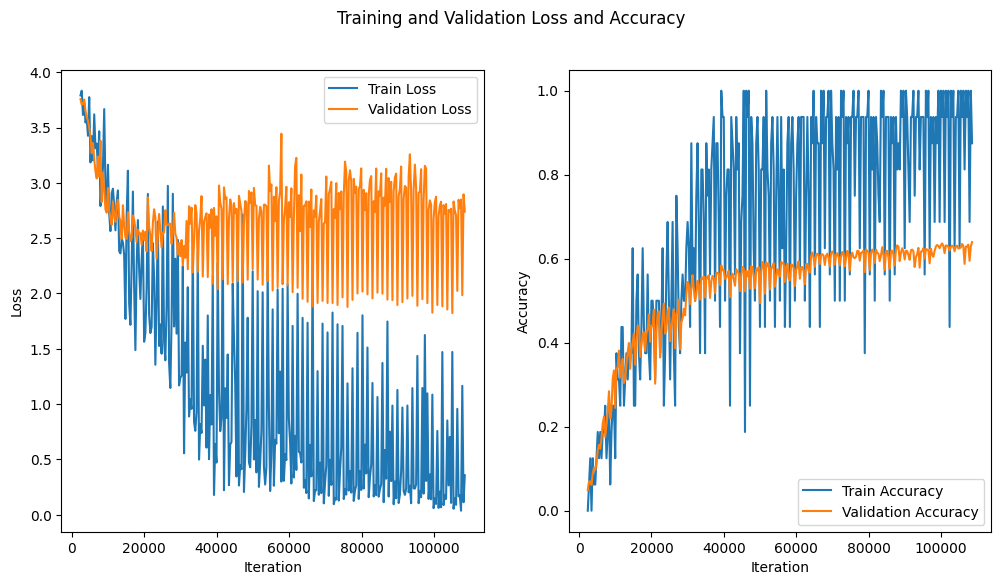

In [17]:
# plots of final loss and accuracy of training and validation data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_iter, train_losses, label='Train Loss')
plt.plot(test_iter, test_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='Train Accuracy')
plt.plot(test_iter, test_accs, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Training and Validation Loss and Accuracy')

plt.show()

**Notes:**

_with_ feature extractor:
- **lr=3e-5, weight_decay=0.01:** Final training loss: 3.722187042236328 accuracy: 0.125
Final validation loss: 3.581272809536426 accuracy: 0.13271103896103897

_without_ feature extractor:
- **lr=3e-5, weight_decay=0.01:** Final training loss: 3.9091145992279053 accuracy: 0.0625
Final validation loss: 3.9065329734381145 accuracy: 0.05113636363636364
- **lr=3e-4, weight_decay=1e-4:** Final training loss: 3.8578035831451416 accuracy: 0.0625
Final validation loss: 3.8629037931367947 accuracy: 0.05113636363636364
- **10 epochs:** Epoch [1/10], Step [1000/1378], Train loss: 3.8586, Train accuracy: 0.0000
Test Loss: 3.8736, Test Accuracy: 0.0511
Model saved to checkpoints_11-25_14-39-54/model_epoch_1.pth
Epoch [2/10], Step [1000/1378], Train loss: 3.7815, Train accuracy: 0.0000
Test Loss: 3.8309, Test Accuracy: 0.0511
Model saved to checkpoints_11-25_14-39-54/model_epoch_2.pth
Epoch [3/10], Step [1000/1378], Train loss: 3.7240, Train accuracy: 0.0000
Test Loss: 3.8027, Test Accuracy: 0.0511
Model saved to checkpoints_11-25_14-39-54/model_epoch_3.pth
Epoch [4/10], Step [1000/1378], Train loss: 3.6817, Train accuracy: 0.0000
Test Loss: 3.7847, Test Accuracy: 0.0511
Model saved to checkpoints_11-25_14-39-54/model_epoch_4.pth
Epoch [5/10], Step [1000/1378], Train loss: 3.6327, Train accuracy: 0.0625
Test Loss: 3.7637, Test Accuracy: 0.0548
Model saved to checkpoints_11-25_14-39-54/model_epoch_5.pth
Epoch [6/10], Step [1000/1378], Train loss: 3.1374, Train accuracy: 0.1875
Test Loss: 3.4809, Test Accuracy: 0.1343
Model saved to checkpoints_11-25_14-39-54/model_epoch_6.pth
Epoch [7/10], Step [1000/1378], Train loss: 2.5359, Train accuracy: 0.3125
Test Loss: 3.1597, Test Accuracy: 0.1928
Model saved to checkpoints_11-25_14-39-54/model_epoch_7.pth
Epoch [8/10], Step [1000/1378], Train loss: 1.9593, Train accuracy: 0.3750
Test Loss: 2.8891, Test Accuracy: 0.2646
Model saved to checkpoints_11-25_14-39-54/model_epoch_8.pth
Epoch [9/10], Step [1000/1378], Train loss: 1.4299, Train accuracy: 0.5625
Test Loss: 2.5677, Test Accuracy: 0.3758
Model saved to checkpoints_11-25_14-39-54/model_epoch_9.pth
Epoch [10/10], Step [1000/1378], Train loss: 0.8334, Train accuracy: 0.8125
Test Loss: 2.3671, Test Accuracy: 0.4614
Model saved to checkpoints_11-25_14-39-54/model_epoch_10.pth

Final training loss: 0.8333953619003296 accuracy: 0.8125
Final validation loss: 2.3671497780007202 accuracy: 0.4614448051948052
Final model saved to /final_model.pth

- try batch normalisation: Final training loss: 1.1365776062011719 accuracy: 0.875
Final validation loss: 27.289619705893777 accuracy: 0.037337662337662336
- **added dropout:** Epoch [1/1], Step [500/1378], Train loss: 3.0752, Train accuracy: 0.3125
Test Loss: 12.0622, Test Accuracy: 0.0605
Epoch [1/1], Step [1000/1378], Train loss: 3.8823, Train accuracy: 0.1875
Test Loss: 3.8838, Test Accuracy: 0.0463
Model saved to checkpoints_11-26_07-26-57/model_epoch_1.pth

Final training loss: 3.8823254108428955 accuracy: 0.1875
Final validation loss: 3.883833321658048 accuracy: 0.04626623376623377
- **lr=3e-4, weight_decay=1e-2:** Epoch [1/1], Step [500/1378], Train loss: 2.9467, Train accuracy: 0.3750
Test Loss: 7.2108, Test Accuracy: 0.0743
Epoch [1/1], Step [1000/1378], Train loss: 3.6674, Train accuracy: 0.0625
Test Loss: 3.7200, Test Accuracy: 0.1002
Model saved to checkpoints_11-26_07-40-09/model_epoch_1.pth

Final training loss: 3.6674227714538574 accuracy: 0.0625
Final validation loss: 3.7200061129285142 accuracy: 0.1002435064935065
Final model saved to /final_model.pth
- **lr=3e-4, weight_decay=1e-1:** Epoch [1/1], Step [689/1378], Train loss: 3.2267, Train accuracy: 0.1250
Test Loss: 39.7332, Test Accuracy: 0.0373
Epoch [1/1], Step [1378/1378], Train loss: 3.8267, Train accuracy: 0.0714
Test Loss: 3.8422, Test Accuracy: 0.0548
Model saved to checkpoints_11-26_07-51-10/model_epoch_1.pth

Final training loss: 3.826742172241211 accuracy: 0.07142857142857142
Final validation loss: 3.84219745382086 accuracy: 0.05478896103896104
Final model saved to /final_model.pth
- let's remove batchnorm and keep dropout and readjust weight decay: Epoch [1/1], Step [689/1378], Train loss: 3.8826, Train accuracy: 0.0000
Test Loss: 3.8835, Test Accuracy: 0.0511
- batchnorm seems to change the outcomes a lot but results in overfitting
- **no batchnorm, dropout, lr=3e-4, weight_decay=1e-3:** Epoch [1/20], Step [689/1378], Train loss: 3.8826, Train accuracy: 0.0000
Test Loss: 3.8835, Test Accuracy: 0.0511
Epoch [1/20], Step [1378/1378], Train loss: 3.8967, Train accuracy: 0.0000
Test Loss: 3.8584, Test Accuracy: 0.0511
Model saved to checkpoints_11-26_09-39-21/model_epoch_1.pth
Epoch [2/20], Step [689/1378], Train loss: 3.8157, Train accuracy: 0.0000
Test Loss: 3.8381, Test Accuracy: 0.0511
Epoch [2/20], Step [1378/1378], Train loss: 3.8821, Train accuracy: 0.0000
Test Loss: 3.8210, Test Accuracy: 0.0511
Model saved to checkpoints_11-26_09-39-21/model_epoch_2.pth
Epoch [3/20], Step [689/1378], Train loss: 3.7665, Train accuracy: 0.0000
Test Loss: 3.8079, Test Accuracy: 0.0511
Epoch [3/20], Step [1378/1378], Train loss: 3.8764, Train accuracy: 0.0000
Test Loss: 3.7971, Test Accuracy: 0.0511
Model saved to checkpoints_11-26_09-39-21/model_epoch_3.pth
Epoch [4/20], Step [689/1378], Train loss: 3.7312, Train accuracy: 0.2500
Test Loss: 3.7888, Test Accuracy: 0.0548
Epoch [4/20], Step [1378/1378], Train loss: 3.8628, Train accuracy: 0.0714
Test Loss: 3.7621, Test Accuracy: 0.0548
Model saved to checkpoints_11-26_09-39-21/model_epoch_4.pth
Epoch [5/20], Step [689/1378], Train loss: 3.6156, Train accuracy: 0.2500
Test Loss: 3.7550, Test Accuracy: 0.0548
Epoch [5/20], Step [1378/1378], Train loss: 3.5863, Train accuracy: 0.0714
Test Loss: 3.6156, Test Accuracy: 0.0946
Model saved to checkpoints_11-26_09-39-21/model_epoch_5.pth
Epoch [6/20], Step [689/1378], Train loss: 3.4459, Train accuracy: 0.2500
Test Loss: 3.5688, Test Accuracy: 0.0974
Epoch [6/20], Step [1378/1378], Train loss: 3.5571, Train accuracy: 0.1429
Test Loss: 3.4508, Test Accuracy: 0.1197
Model saved to checkpoints_11-26_09-39-21/model_epoch_6.pth
Epoch [7/20], Step [689/1378], Train loss: 2.9947, Train accuracy: 0.2500
Test Loss: 3.4292, Test Accuracy: 0.1250
Epoch [7/20], Step [1378/1378], Train loss: 3.4386, Train accuracy: 0.0714
Test Loss: 3.2594, Test Accuracy: 0.1729
Model saved to checkpoints_11-26_09-39-21/model_epoch_7.pth
Epoch [8/20], Step [689/1378], Train loss: 3.0706, Train accuracy: 0.3125
Test Loss: 3.2220, Test Accuracy: 0.1907
Epoch [8/20], Step [1378/1378], Train loss: 3.3021, Train accuracy: 0.2143
Test Loss: 3.0698, Test Accuracy: 0.2009
Model saved to checkpoints_11-26_09-39-21/model_epoch_8.pth
Epoch [9/20], Step [689/1378], Train loss: 2.8142, Train accuracy: 0.3125
Test Loss: 3.1078, Test Accuracy: 0.1887
Epoch [9/20], Step [1378/1378], Train loss: 3.1340, Train accuracy: 0.2143
Test Loss: 2.8002, Test Accuracy: 0.2731
Model saved to checkpoints_11-26_09-39-21/model_epoch_9.pth
Epoch [10/20], Step [689/1378], Train loss: 3.1712, Train accuracy: 0.1250
Test Loss: 2.8940, Test Accuracy: 0.2419
Epoch [10/20], Step [1378/1378], Train loss: 2.6017, Train accuracy: 0.3571
Test Loss: 2.5704, Test Accuracy: 0.3588
- still training slowly
- ok but I would argue batchnorm makes sense, but the model is not learning properly
- **with batchnorm, lr=1e-5, weight_decay=1e-2:** Epoch [1/5], Step [689/1378], Train loss: 3.2199, Train accuracy: 0.2500
Test Loss: 7.7746, Test Accuracy: 0.0195
Epoch [1/5], Step [1378/1378], Train loss: 3.9224, Train accuracy: 0.0714
Test Loss: 3.9106, Test Accuracy: 0.0179
Model saved to checkpoints_11-26_15-49-06/model_epoch_1.pth
Epoch [2/5], Step [689/1378], Train loss: 3.0229, Train accuracy: 0.4375
Test Loss: 4.0102, Test Accuracy: 0.1059
Epoch [2/5], Step [1378/1378], Train loss: 3.9216, Train accuracy: 0.0714
Test Loss: 3.9090, Test Accuracy: 0.0179
Model saved to checkpoints_11-26_15-49-06/model_epoch_2.pth
Epoch [3/5], Step [689/1378], Train loss: 2.8098, Train accuracy: 0.4375
Test Loss: 3.9594, Test Accuracy: 0.0812
Epoch [3/5], Step [1378/1378], Train loss: 3.9208, Train accuracy: 0.0000
Test Loss: 3.9074, Test Accuracy: 0.0511
Model saved to checkpoints_11-26_15-49-06/model_epoch_3.pth
Epoch [4/5], Step [689/1378], Train loss: 2.6070, Train accuracy: 0.4375
Test Loss: 4.7324, Test Accuracy: 0.0674
Epoch [4/5], Step [1378/1378], Train loss: 3.9199, Train accuracy: 0.0000
Test Loss: 3.9060, Test Accuracy: 0.0503
Model saved to checkpoints_11-26_15-49-06/model_epoch_4.pth
Epoch [5/5], Step [689/1378], Train loss: 2.6893, Train accuracy: 0.5625
Test Loss: 3.8790, Test Accuracy: 0.0998
Epoch [5/5], Step [1378/1378], Train loss: 3.9190, Train accuracy: 0.0000
Test Loss: 3.9042, Test Accuracy: 0.0511
Model saved to checkpoints_11-26_15-49-06/model_epoch_5.pth

Final training loss: 3.918975830078125 accuracy: 0.0
Final validation loss: 3.904191467669103 accuracy: 0.05113636363636364
Final model saved to /final_model.pth
- **weight decay = .1 - model still not learning:** Epoch [1/5], Step [344/1378], Train loss: 3.4690, Train accuracy: 0.3125
Test Loss: 5.7868, Test Accuracy: 0.0532
Epoch [1/5], Step [688/1378], Train loss: 3.9242, Train accuracy: 0.0000
Test Loss: 3.9115, Test Accuracy: 0.0183
Epoch [1/5], Step [1032/1378], Train loss: 3.9213, Train accuracy: 0.0000
Test Loss: 3.9111, Test Accuracy: 0.0179
Epoch [1/5], Step [1376/1378], Train loss: 3.9174, Train accuracy: 0.0000
Test Loss: 3.9101, Test Accuracy: 0.0207
Model saved to checkpoints_11-27_08-05-50/model_epoch_1.pth
Epoch [2/5], Step [344/1378], Train loss: 2.9455, Train accuracy: 0.4375
Test Loss: 3.9779, Test Accuracy: 0.0962
Epoch [2/5], Step [688/1378], Train loss: 3.9220, Train accuracy: 0.0000
Test Loss: 3.9098, Test Accuracy: 0.0179
Epoch [2/5], Step [1032/1378], Train loss: 3.9189, Train accuracy: 0.0000
Test Loss: 3.9093, Test Accuracy: 0.0179
Epoch [2/5], Step [1376/1378], Train loss: 3.9163, Train accuracy: 0.0000
Test Loss: 3.9093, Test Accuracy: 0.0507
Model saved to checkpoints_11-27_08-05-50/model_epoch_2.pth
Epoch [3/5], Step [344/1378], Train loss: 3.0611, Train accuracy: 0.4375
Test Loss: 4.4968, Test Accuracy: 0.0791
Epoch [3/5], Step [688/1378], Train loss: 3.9165, Train accuracy: 0.0000
Test Loss: 3.9078, Test Accuracy: 0.0511
Epoch [3/5], Step [1032/1378], Train loss: 4.0507, Train accuracy: 0.0000
Test Loss: 3.9063, Test Accuracy: 0.0556
Epoch [3/5], Step [1376/1378], Train loss: 3.9151, Train accuracy: 0.0000
Test Loss: 3.9079, Test Accuracy: 0.0511
Model saved to checkpoints_11-27_08-05-50/model_epoch_3.pth
Epoch [4/5], Step [344/1378], Train loss: 2.8980, Train accuracy: 0.5000
Test Loss: 4.0230, Test Accuracy: 0.0889
Epoch [4/5], Step [688/1378], Train loss: 3.9179, Train accuracy: 0.0000
Test Loss: 3.9064, Test Accuracy: 0.0507
Epoch [4/5], Step [1032/1378], Train loss: 3.9144, Train accuracy: 0.0625
Test Loss: 3.9060, Test Accuracy: 0.0511
Epoch [4/5], Step [1376/1378], Train loss: 3.9139, Train accuracy: 0.0000
Test Loss: 3.9062, Test Accuracy: 0.0511
Model saved to checkpoints_11-27_08-05-50/model_epoch_4.pth
Epoch [5/5], Step [344/1378], Train loss: 3.2460, Train accuracy: 0.3750
Test Loss: 4.7231, Test Accuracy: 0.0524
Epoch [5/5], Step [688/1378], Train loss: 3.9176, Train accuracy: 0.0000
Test Loss: 3.9049, Test Accuracy: 0.0511
Epoch [5/5], Step [1032/1378], Train loss: 3.8878, Train accuracy: 0.0000
Test Loss: 3.9014, Test Accuracy: 0.0308
Epoch [5/5], Step [1376/1378], Train loss: 3.9128, Train accuracy: 0.0000
Test Loss: 3.9016, Test Accuracy: 0.0511
Model saved to checkpoints_11-27_08-05-50/model_epoch_5.pth

Final training loss: 3.9127585887908936 accuracy: 0.0
Final validation loss: 3.9016316509866096 accuracy: 0.05113636363636364
Final model saved to /final_model.pth
- increase learning rate
- add a layer
- more epochs
- ...

- **added a layer:** Epoch [1/5], Step [344/1378], Train loss: 3.3977, Train accuracy: 0.3750
Test Loss: 5.1444, Test Accuracy: 0.0438
Epoch [1/5], Step [688/1378], Train loss: 3.9046, Train accuracy: 0.0625
Test Loss: 3.9168, Test Accuracy: 0.0110
Epoch [1/5], Step [1032/1378], Train loss: 3.9190, Train accuracy: 0.0000
Test Loss: 3.9169, Test Accuracy: 0.0126
Epoch [1/5], Step [1376/1378], Train loss: 3.9129, Train accuracy: 0.0625
Test Loss: 3.9160, Test Accuracy: 0.0126
Model saved to checkpoints_11-27_09-49-06/model_epoch_1.pth
Epoch [2/5], Step [344/1378], Train loss: 3.0668, Train accuracy: 0.5000
Test Loss: 3.4791, Test Accuracy: 0.1611
Epoch [2/5], Step [688/1378], Train loss: 3.9200, Train accuracy: 0.0000
Test Loss: 3.9155, Test Accuracy: 0.0138
Epoch [2/5], Step [1032/1378], Train loss: 3.9168, Train accuracy: 0.0000
Test Loss: 3.9149, Test Accuracy: 0.0138
Epoch [2/5], Step [1376/1378], Train loss: 3.9116, Train accuracy: 0.0000
Test Loss: 3.9144, Test Accuracy: 0.0158
Model saved to checkpoints_11-27_09-49-06/model_epoch_2.pth
Epoch [3/5], Step [344/1378], Train loss: 2.6518, Train accuracy: 0.5000
Test Loss: 3.3406, Test Accuracy: 0.1964
Epoch [3/5], Step [688/1378], Train loss: 3.9179, Train accuracy: 0.0000
Test Loss: 3.9135, Test Accuracy: 0.0158
Epoch [3/5], Step [1032/1378], Train loss: 3.9146, Train accuracy: 0.0625
Test Loss: 3.9129, Test Accuracy: 0.0158
Epoch [3/5], Step [1376/1378], Train loss: 3.9103, Train accuracy: 0.1250
Test Loss: 3.9124, Test Accuracy: 0.0479
Model saved to checkpoints_11-27_09-49-06/model_epoch_3.pth

**adjusted weight decay:** Epoch [1/5], Step [344/1378], Train loss: 3.0697, Train accuracy: 0.4375
Test Loss: 9.8011, Test Accuracy: 0.0568
Epoch [1/5], Step [688/1378], Train loss: 3.9121, Train accuracy: 0.0625
Test Loss: 3.9109, Test Accuracy: 0.0479
Epoch [1/5], Step [1032/1378], Train loss: 3.8449, Train accuracy: 0.0000
Test Loss: 3.8983, Test Accuracy: 0.0479
Epoch [1/5], Step [1376/1378], Train loss: 3.9031, Train accuracy: 0.1250
Test Loss: 3.9010, Test Accuracy: 0.0479
Model saved to checkpoints_11-27_10-40-34/model_epoch_1.pth
Epoch [2/5], Step [344/1378], Train loss: 2.9829, Train accuracy: 0.3125
Test Loss: 7.3576, Test Accuracy: 0.0690
Epoch [2/5], Step [688/1378], Train loss: 3.8978, Train accuracy: 0.0625
Test Loss: 3.8953, Test Accuracy: 0.0479
Epoch [2/5], Step [1032/1378], Train loss: 3.8885, Train accuracy: 0.0000
Test Loss: 3.8906, Test Accuracy: 0.0479
Epoch [2/5], Step [1376/1378], Train loss: 3.8932, Train accuracy: 0.1250
Test Loss: 3.8862, Test Accuracy: 0.0479
Model saved to checkpoints_11-27_10-40-34/model_epoch_2.pth
Epoch [3/5], Step [344/1378], Train loss: 3.0613, Train accuracy: 0.3125
Test Loss: 6.3818, Test Accuracy: 0.0718
Epoch [3/5], Step [688/1378], Train loss: 3.8837, Train accuracy: 0.0625
Test Loss: 3.8810, Test Accuracy: 0.0479
Epoch [3/5], Step [1032/1378], Train loss: 3.8744, Train accuracy: 0.0000
Test Loss: 3.8767, Test Accuracy: 0.0479
Epoch [3/5], Step [1376/1378], Train loss: 3.8841, Train accuracy: 0.1250
Test Loss: 3.8727, Test Accuracy: 0.0479
Model saved to checkpoints_11-27_10-40-34/model_epoch_3.pth
Epoch [4/5], Step [344/1378], Train loss: 3.4521, Train accuracy: 0.3125
Test Loss: 7.5211, Test Accuracy: 0.0844
Epoch [4/5], Step [688/1378], Train loss: 3.8706, Train accuracy: 0.0625
Test Loss: 3.8684, Test Accuracy: 0.0479
Epoch [4/5], Step [1032/1378], Train loss: 3.8619, Train accuracy: 0.0000
Test Loss: 3.8647, Test Accuracy: 0.0479
Epoch [4/5], Step [1376/1378], Train loss: 3.8677, Train accuracy: 0.0000
Test Loss: 3.8887, Test Accuracy: 0.0312
Model saved to checkpoints_11-27_10-40-34/model_epoch_4.pth
Epoch [5/5], Step [344/1378], Train loss: 3.2945, Train accuracy: 0.3125
Test Loss: 5.7542, Test Accuracy: 0.0800
Epoch [5/5], Step [688/1378], Train loss: 3.8592, Train accuracy: 0.0625
Test Loss: 3.8574, Test Accuracy: 0.0479
Epoch [5/5], Step [1032/1378], Train loss: 3.8502, Train accuracy: 0.0000
Test Loss: 3.8540, Test Accuracy: 0.0479
Epoch [5/5], Step [1376/1378], Train loss: 3.8698, Train accuracy: 0.1250
Test Loss: 3.8509, Test Accuracy: 0.0479
Model saved to checkpoints_11-27_10-40-34/model_epoch_5.pth

Final training loss: 3.869847297668457 accuracy: 0.125
Final validation loss: 3.850856623092255 accuracy: 0.04788961038961039
Final model saved to /final_model.pth

**back to non batchnorm and dropout 0.5:** more stable training, but still unstable and still overfitting:

final_model_path =  os.path.join(save_dir, f"/final_model.pth")
torch.save(cnn.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")
Epoch [1/20], Step [344/1378], Train loss: 3.8070, Train accuracy: 0.0000
Test Loss: 3.8473, Test Accuracy: 0.0511
Epoch [1/20], Step [688/1378], Train loss: 3.8513, Train accuracy: 0.0000
Test Loss: 3.8377, Test Accuracy: 0.0511
Epoch [1/20], Step [1032/1378], Train loss: 3.8295, Train accuracy: 0.0625
Test Loss: 3.8285, Test Accuracy: 0.0511
Epoch [1/20], Step [1376/1378], Train loss: 3.8632, Train accuracy: 0.0000
Test Loss: 3.8207, Test Accuracy: 0.0511
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [2/20], Step [344/1378], Train loss: 3.7454, Train accuracy: 0.0000
Test Loss: 3.8138, Test Accuracy: 0.0511
Epoch [2/20], Step [688/1378], Train loss: 3.8210, Train accuracy: 0.0000
Test Loss: 3.8077, Test Accuracy: 0.0511
Epoch [2/20], Step [1032/1378], Train loss: 3.7993, Train accuracy: 0.0625
Test Loss: 3.8019, Test Accuracy: 0.0511
Epoch [2/20], Step [1376/1378], Train loss: 3.8371, Train accuracy: 0.0625
Test Loss: 3.7883, Test Accuracy: 0.0548
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [3/20], Step [344/1378], Train loss: 3.7026, Train accuracy: 0.1250
Test Loss: 3.7927, Test Accuracy: 0.0548
Epoch [3/20], Step [688/1378], Train loss: 3.7847, Train accuracy: 0.0000
Test Loss: 3.8011, Test Accuracy: 0.0373
Epoch [3/20], Step [1032/1378], Train loss: 3.7358, Train accuracy: 0.0625
Test Loss: 3.7621, Test Accuracy: 0.0511
Epoch [3/20], Step [1376/1378], Train loss: 3.8292, Train accuracy: 0.0625
Test Loss: 3.7564, Test Accuracy: 0.0548
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [4/20], Step [344/1378], Train loss: 3.6131, Train accuracy: 0.1250
Test Loss: 3.7653, Test Accuracy: 0.0548
Epoch [4/20], Step [688/1378], Train loss: 3.8290, Train accuracy: 0.0000
Test Loss: 3.7626, Test Accuracy: 0.0617
Epoch [4/20], Step [1032/1378], Train loss: 3.6922, Train accuracy: 0.1250
Test Loss: 3.7160, Test Accuracy: 0.0812
Epoch [4/20], Step [1376/1378], Train loss: 4.1689, Train accuracy: 0.0000
Test Loss: 3.6271, Test Accuracy: 0.0913
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [5/20], Step [344/1378], Train loss: 3.5627, Train accuracy: 0.1250
Test Loss: 3.6265, Test Accuracy: 0.0942
Epoch [5/20], Step [688/1378], Train loss: 3.8128, Train accuracy: 0.1250
Test Loss: 3.5478, Test Accuracy: 0.1108
Epoch [5/20], Step [1032/1378], Train loss: 3.4558, Train accuracy: 0.0625
Test Loss: 3.4693, Test Accuracy: 0.1230
Epoch [5/20], Step [1376/1378], Train loss: 4.1124, Train accuracy: 0.0000
Test Loss: 3.3936, Test Accuracy: 0.1485
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [6/20], Step [344/1378], Train loss: 3.4545, Train accuracy: 0.1250
Test Loss: 3.4483, Test Accuracy: 0.1335
Epoch [6/20], Step [688/1378], Train loss: 3.3615, Train accuracy: 0.1875
Test Loss: 3.2954, Test Accuracy: 0.1627
Epoch [6/20], Step [1032/1378], Train loss: 3.0339, Train accuracy: 0.1250
Test Loss: 3.2401, Test Accuracy: 0.1713
Epoch [6/20], Step [1376/1378], Train loss: 3.5311, Train accuracy: 0.0625
Test Loss: 3.1489, Test Accuracy: 0.1944
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [7/20], Step [344/1378], Train loss: 3.0726, Train accuracy: 0.2500
Test Loss: 3.2497, Test Accuracy: 0.1672
Epoch [7/20], Step [688/1378], Train loss: 2.9028, Train accuracy: 0.2500
Test Loss: 3.1035, Test Accuracy: 0.2001
Epoch [7/20], Step [1032/1378], Train loss: 2.7117, Train accuracy: 0.1875
Test Loss: 2.9781, Test Accuracy: 0.2342
Epoch [7/20], Step [1376/1378], Train loss: 3.2774, Train accuracy: 0.1250
Test Loss: 2.9027, Test Accuracy: 0.2630
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [8/20], Step [344/1378], Train loss: 2.8352, Train accuracy: 0.1875
Test Loss: 3.1029, Test Accuracy: 0.1976
Epoch [8/20], Step [688/1378], Train loss: 2.6866, Train accuracy: 0.3125
Test Loss: 2.9022, Test Accuracy: 0.2439
Epoch [8/20], Step [1032/1378], Train loss: 2.3449, Train accuracy: 0.3750
Test Loss: 2.7718, Test Accuracy: 0.3011
Epoch [8/20], Step [1376/1378], Train loss: 3.0198, Train accuracy: 0.2500
Test Loss: 2.6764, Test Accuracy: 0.3251
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [9/20], Step [344/1378], Train loss: 2.7229, Train accuracy: 0.3750
Test Loss: 2.8731, Test Accuracy: 0.2683
Epoch [9/20], Step [688/1378], Train loss: 2.4755, Train accuracy: 0.4375
Test Loss: 2.6847, Test Accuracy: 0.3182
Epoch [9/20], Step [1032/1378], Train loss: 1.9677, Train accuracy: 0.5000
Test Loss: 2.5773, Test Accuracy: 0.3454
Epoch [9/20], Step [1376/1378], Train loss: 2.6289, Train accuracy: 0.3125
Test Loss: 2.4568, Test Accuracy: 0.3709
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [10/20], Step [344/1378], Train loss: 2.2468, Train accuracy: 0.4375
Test Loss: 2.7901, Test Accuracy: 0.3093
Epoch [10/20], Step [688/1378], Train loss: 2.2658, Train accuracy: 0.5000
Test Loss: 2.4622, Test Accuracy: 0.3868
Epoch [10/20], Step [1032/1378], Train loss: 1.6520, Train accuracy: 0.6250
Test Loss: 2.3921, Test Accuracy: 0.4091
Epoch [10/20], Step [1376/1378], Train loss: 2.2771, Train accuracy: 0.3750
Test Loss: 2.2802, Test Accuracy: 0.4444
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [11/20], Step [344/1378], Train loss: 2.4926, Train accuracy: 0.3750
Test Loss: 2.6920, Test Accuracy: 0.3332
Epoch [11/20], Step [688/1378], Train loss: 1.5384, Train accuracy: 0.6250
Test Loss: 2.3173, Test Accuracy: 0.4363
Epoch [11/20], Step [1032/1378], Train loss: 1.3034, Train accuracy: 0.6875
Test Loss: 2.3149, Test Accuracy: 0.4481
Epoch [11/20], Step [1376/1378], Train loss: 2.4201, Train accuracy: 0.4375
Test Loss: 2.3147, Test Accuracy: 0.4606
Epoch [12/20], Step [344/1378], Train loss: 2.1987, Train accuracy: 0.3750
Test Loss: 2.6649, Test Accuracy: 0.4042
Epoch [12/20], Step [688/1378], Train loss: 1.4738, Train accuracy: 0.6875
Test Loss: 2.3166, Test Accuracy: 0.4671
Epoch [12/20], Step [1032/1378], Train loss: 1.1334, Train accuracy: 0.6875
Test Loss: 2.2924, Test Accuracy: 0.4675
Epoch [12/20], Step [1376/1378], Train loss: 1.6313, Train accuracy: 0.5625
Test Loss: 2.1440, Test Accuracy: 0.5252
New best model saved to checkpoints_11-28_09-56-06/best_model.pth
Epoch [13/20], Step [344/1378], Train loss: 2.3999, Train accuracy: 0.3125
Test Loss: 2.4957, Test Accuracy: 0.3713
Epoch [13/20], Step [688/1378], Train loss: 1.6529, Train accuracy: 0.6875
Test Loss: 2.2899, Test Accuracy: 0.4789
Epoch [13/20], Step [1032/1378], Train loss: 0.8505, Train accuracy: 0.8125
Test Loss: 2.2886, Test Accuracy: 0.5110
Epoch [13/20], Step [1376/1378], Train loss: 1.8904, Train accuracy: 0.6250
Test Loss: 2.2773, Test Accuracy: 0.5142
Epoch [14/20], Step [344/1378], Train loss: 2.3450, Train accuracy: 0.4375
Test Loss: 2.4544, Test Accuracy: 0.4119
Epoch [14/20], Step [688/1378], Train loss: 0.9908, Train accuracy: 0.6875
Test Loss: 2.2022, Test Accuracy: 0.5288
Epoch [14/20], Step [1032/1378], Train loss: 0.8651, Train accuracy: 0.8125
Test Loss: 2.4062, Test Accuracy: 0.5073
Epoch [14/20], Step [1376/1378], Train loss: 1.3350, Train accuracy: 0.6875
Test Loss: 2.2210, Test Accuracy: 0.5459
Epoch [15/20], Step [344/1378], Train loss: 2.5992, Train accuracy: 0.2500
Test Loss: 2.4392, Test Accuracy: 0.3981
Epoch [15/20], Step [688/1378], Train loss: 0.7940, Train accuracy: 0.7500
Test Loss: 2.2887, Test Accuracy: 0.5296
Epoch [15/20], Step [1032/1378], Train loss: 0.6657, Train accuracy: 0.8125
Test Loss: 2.1906, Test Accuracy: 0.5471
Epoch [15/20], Step [1376/1378], Train loss: 0.8168, Train accuracy: 0.7500
Test Loss: 2.3228, Test Accuracy: 0.5540
Epoch [16/20], Step [344/1378], Train loss: 2.1570, Train accuracy: 0.3750
Test Loss: 2.3282, Test Accuracy: 0.4420
Epoch [16/20], Step [688/1378], Train loss: 0.7870, Train accuracy: 0.7500
Test Loss: 2.2067, Test Accuracy: 0.5649
Epoch [16/20], Step [1032/1378], Train loss: 0.5542, Train accuracy: 0.8750
Test Loss: 2.2065, Test Accuracy: 0.5739
Epoch [16/20], Step [1376/1378], Train loss: 1.8514, Train accuracy: 0.7500
Test Loss: 2.1680, Test Accuracy: 0.5909
Epoch [17/20], Step [344/1378], Train loss: 2.6265, Train accuracy: 0.3125
Test Loss: 2.3822, Test Accuracy: 0.4359
Epoch [17/20], Step [688/1378], Train loss: 0.6436, Train accuracy: 0.8750
Test Loss: 2.2531, Test Accuracy: 0.5694
Epoch [17/20], Step [1032/1378], Train loss: 1.0518, Train accuracy: 0.7500
Test Loss: 2.3508, Test Accuracy: 0.5710
Epoch [17/20], Step [1376/1378], Train loss: 1.6882, Train accuracy: 0.7500
Test Loss: 2.5761, Test Accuracy: 0.5532
Epoch [18/20], Step [344/1378], Train loss: 2.1755, Train accuracy: 0.2500
Test Loss: 2.2447, Test Accuracy: 0.4972
Epoch [18/20], Step [688/1378], Train loss: 0.4972, Train accuracy: 0.8750
Test Loss: 2.3168, Test Accuracy: 0.5828
Epoch [18/20], Step [1032/1378], Train loss: 0.5984, Train accuracy: 0.8125
Test Loss: 2.4507, Test Accuracy: 0.5759
Epoch [18/20], Step [1376/1378], Train loss: 1.2453, Train accuracy: 0.6875
Test Loss: 2.8489, Test Accuracy: 0.5495
Epoch [19/20], Step [344/1378], Train loss: 2.3646, Train accuracy: 0.3750
Test Loss: 2.2903, Test Accuracy: 0.4550
Epoch [19/20], Step [688/1378], Train loss: 0.5893, Train accuracy: 0.8125
Test Loss: 2.1947, Test Accuracy: 0.6051
Epoch [19/20], Step [1032/1378], Train loss: 1.2808, Train accuracy: 0.7500
Test Loss: 2.5379, Test Accuracy: 0.5479
Epoch [19/20], Step [1376/1378], Train loss: 1.1156, Train accuracy: 0.6875
Test Loss: 2.6786, Test Accuracy: 0.5747
Epoch [20/20], Step [344/1378], Train loss: 2.4394, Train accuracy: 0.4375
Test Loss: 2.1871, Test Accuracy: 0.5012
Epoch [20/20], Step [688/1378], Train loss: 0.6354, Train accuracy: 0.8125
Test Loss: 2.4555, Test Accuracy: 0.5909
Epoch [20/20], Step [1032/1378], Train loss: 1.2214, Train accuracy: 0.7500
Test Loss: 2.5266, Test Accuracy: 0.5877
Epoch [20/20], Step [1376/1378], Train loss: 2.2376, Train accuracy: 0.8125
Test Loss: 2.4627, Test Accuracy: 0.6153

- **conclusion:** lower learning rate, try a longer epoch